In [76]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [77]:
days_to_sec = lambda t: t * 24 * 3600

In [78]:
L = 500
p0 = 100e5
pinj = 150e5
pprod = 50e5
k = 1e-14
mu = 1e-3
phi = 0.2
rho0 = 1000
cf = 1e-9
pop = 120e5
T = 10
tau = 1/24
h = 5

In [79]:
rho = lambda p: rho0 * (1 + cf*(p - pop))

In [80]:
def gen_grid(xbegin, xend, h, T, tau, x0):
    n = int(T/tau) + 1
    m = int((xend - xbegin)/h) + 1
    grid = np.zeros((n, m))
    grid[0, :] = x0
    return grid, n, m

In [81]:
def my_solver(A, d):
    n = len(d)

    a = np.zeros(n)
    b = np.zeros(n)
    c = np.zeros(n)
    for i in range(n):
        b[i] = A[i,i]
        if i > 0:
            a[i] = A[i, i -1]
        if i < n-1:
            c[i] = A[i, i + 1]
    
    x = np.zeros(n)
    p = np.zeros(n)
    q = np.zeros(n)
    
    p[1] = -c[0]/b[0]
    q[1] = d[0]/b[0]
    
    for i in range(1, n-1):
        p[i+1] = -c[i]/(a[i]*p[i] + b[i])
        q[i+1] = (d[i] - a[i]*q[i])/(a[i]*p[i] + b[i])
    x[n-1] = (d[n-1] - a[n-1]*q[n-1])/(p[n-1]*a[n-1] + b[n-1])
    
    for i in range(n-2, -1, -1):
        x[i] = x[i+1]*p[i+1] + q[i+1]
        
    return x

In [82]:
rhofrac = lambda pl, pr: rho(pl) if pl >= pr else rho(pr)

In [83]:
def solve(xbegin, xend, h, T, tau, x0, dt_output=0.1, show=True):
    grid, n, m = gen_grid(xbegin, xend, h, T, tau, x0)
    x = np.arange(xbegin, xend, h)
    
    t = 0
    
    A = np.eye(m)
    d = np.zeros(m)
    d[0] = pinj
    d[-1] = pprod
    t = 0
    t_next_output = dt_output
    for i in range(1, n):
        for j in range(1, m-1):
            A[j, j-1] = k * rhofrac(grid[i-1, j-1], grid[i-1, j])/ (mu * h**2)
            A[j, j+1] = k * rhofrac(grid[i-1, j], grid[i-1, j+1])/ (mu * h**2)
            A[j, j] = -A[j, j-1] - A[j, j+1] - phi * cf * rho0 / days_to_sec(tau)
            d[j] = -phi * cf * rho0 / days_to_sec(tau) * grid[i-1, j]
            
        grid[i, :] = my_solver(A, d)
        
        if t >= t_next_output:
            if show:
                plt.plot(x, grid[i, :], label='t = {:.3f}'.format(t))
                plt.legend(loc='upper left')
                plt.show()
            
            t_next_output += dt_output
            
        t += tau
    return grid

In [84]:
grid = solve(0, L, h, T, tau, p0, show=False)

In [85]:
def show_p(grid, time):
    n = int(T/tau)
    i = int(time/T * n)
    x = np.arange(0, L + 0.1, h)
    plt.plot(x, grid[i, :], label='P for t = {:.1f} days'.format(time))
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

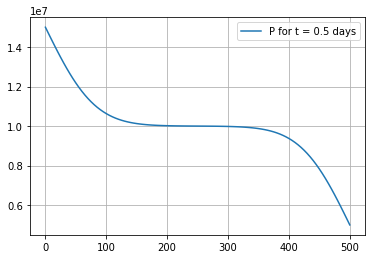

In [86]:
show_p(grid, 0.5)

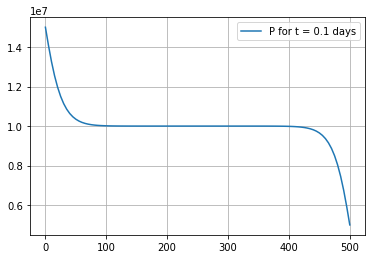

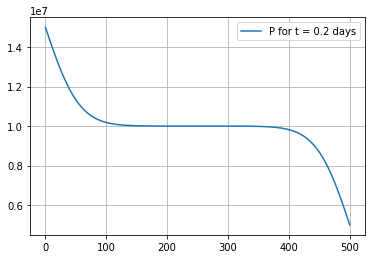

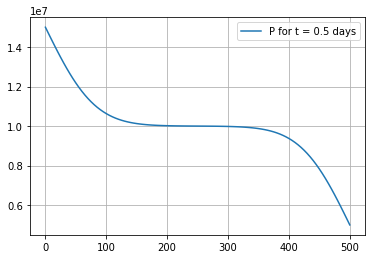

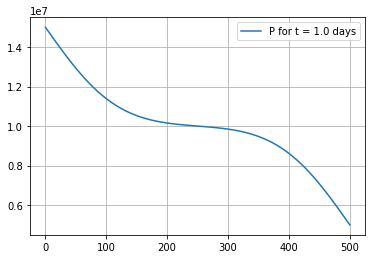

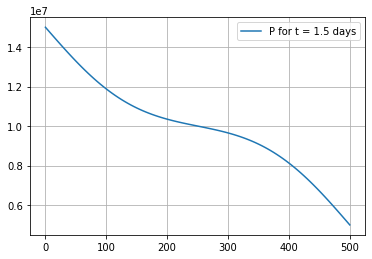

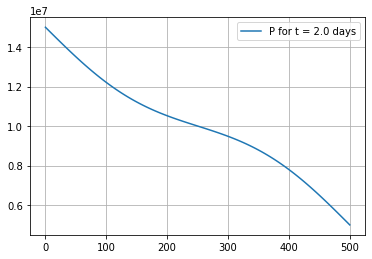

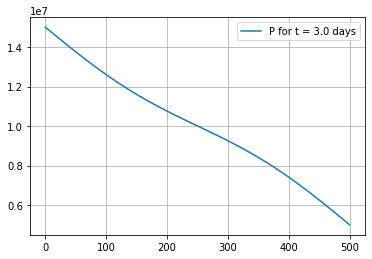

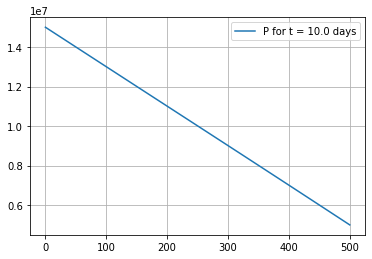

In [87]:
for t in [0.1, 0.25, 0.5, 1, 1.5, 2, 3, 10]:
    show_p(grid, t)